# Analysis of US Health Insurance Dataset

## 1. Overview

The data set was located on the the Kaggle website and is licensed to CC0 Public Domain. It contains 7 columns, all of which will be used for this analysis:

    Age: Age of primary beneficiary
    Sex: Insurance contractor gender, female / male
    BMI: Body mass index, providing an understanding of body, weights that are relatively high or low (Underweight = <18.5, Normal weight = 18.5–24.9, Overweight = 25–29.9, Obesity = BMI of 30 or greater)
    Children: Number of children covered by health insurance / Number of dependents
    Smoker: Smoker / Non - smoker
    Region: The beneficiary's residential area in the US, northeast, southeast, southwest, northwest
    Charges: Individual medical costs billed by health insurance

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.api as stm
from statsmodels.formula.api import ols
from scipy import stats
from tabulate import tabulate
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
#Read dataset
Insurance_df = pd.read_csv("insurance.csv")
Insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print(Insurance_df.columns.tolist()) # examine column names for unusual characters or difficult to understand names

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


In [4]:
Insurance_df.info() #Summary information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
Insurance_df.describe() #Summary information about the dataset

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
Insurance_df.nunique() #count unique values in each column

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

The initial analysis reveals that the data is very clean. The continuous variables appear to have a good range of values allowing for a robust analysis.

## 2. Data Preparation

### Feature Engineering

To allow for the categorical values to be included in regression analysis, one hot encoding will be used to convert them to dummy variables so they become binary yes/no variables. The newly created dataframes will then be concatonated to the existing dataset.

In [7]:
# Convert categorgical variables to binary values using one hot encoding
y = Insurance_df[['smoker', 'sex', 'region']]
# Drop first column from each category (for example, only need 1 column for smokers (yes or no).
# Including all responses would overfit the model.
dummy_df = pd.get_dummies(data=y, drop_first=True)
Insurance_df = pd.concat([Insurance_df, dummy_df], axis=1)
Insurance_df

,age,sex,bmi,children,smoker,region,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,1,0,0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,0,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0,1,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0,0,1


In [8]:
Insurance_df['bmi_group']=pd.cut(x=Insurance_df['bmi'], bins=[0,25,65], labels = ['low', 'high'])
Insurance_df['bmi_group'].value_counts()

high    1091
low      247
Name: bmi_group, dtype: int64

In [9]:
y = Insurance_df[['bmi_group']]
dummy_df = pd.get_dummies(data=y, drop_first=True)
Insurance_df = pd.concat([Insurance_df, dummy_df], axis=1)
Insurance_df

,age,sex,bmi,children,smoker,region,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest,bmi_group,bmi_group_high
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,1,high,1
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,1,0,high,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0,1,0,high,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1,1,0,0,low,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,1,0,0,high,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,1,0,0,high,1
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,0,0,0,high,1
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0,1,0,high,1
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0,0,1,high,1


### Missing Data

In [10]:
Insurance_df.isnull().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
region              0
charges             0
smoker_yes          0
sex_male            0
region_northwest    0
region_southeast    0
region_southwest    0
bmi_group           0
bmi_group_high      0
dtype: int64

There are no null values/missing data.

### Outliers

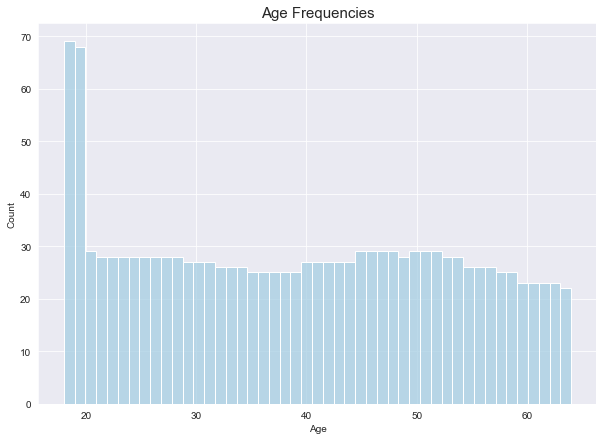

In [11]:
#Frequencies of Age
sns.set_style('darkgrid')
sns.set_palette('Paired')
plt.figure(figsize = (10,7))
sns.histplot(Insurance_df['age'], bins=47);
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Frequencies', fontsize= 15);

There are twice as many 18-year-olds and 19-year-olds as there are any other age group. However, with a reasonable age range of 18-64 there do not appear to be any outliers that need to be removed at this time.

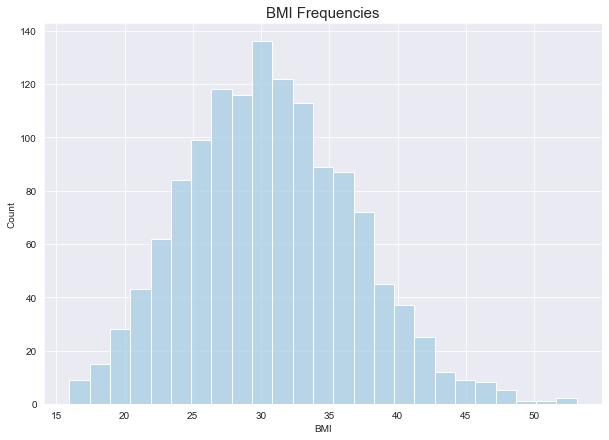

In [12]:
#Frequencies of BMI
plt.figure(figsize = (10,7))
sns.histplot(Insurance_df['bmi']);
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('BMI Frequencies', fontsize= 15);

While there is a fairly standard distribution of BMI in the dataset, by the definition of BMI provided above, a large proportion is considered Overweight or Obese (Underweight = <18.5, Normal weight = 18.5–24.9, Overweight = 25–29.9, Obesity = BMI of 30 or greater). However, there does not appear to be any outliers that need to be removed at this time.

In [13]:
high_bmi = Insurance_df.loc[Insurance_df['bmi'] >= 25]
high_bmi['bmi'].describe()

count    1093.000000
mean       32.559625
std         4.988743
min        25.000000
25%        28.595000
50%        31.900000
75%        35.815000
max        53.130000
Name: bmi, dtype: float64

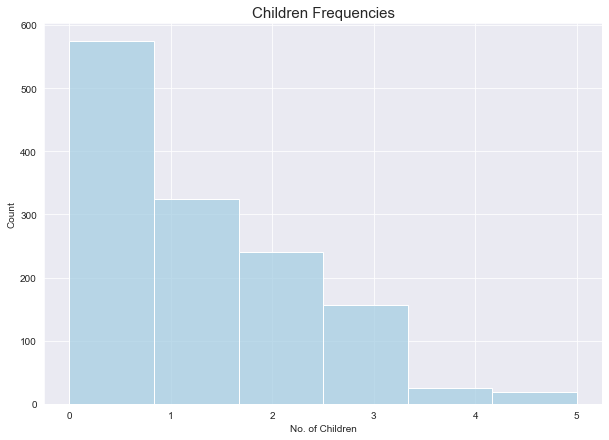

In [14]:
#Frequences of children
plt.figure(figsize = (10,7))
sns.histplot(Insurance_df['children'], bins=6);
plt.xlabel('No. of Children')
plt.ylabel('Count')
plt.title('Children Frequencies', fontsize= 15);

There do not appear to be any outliers that need to be removed at this point.

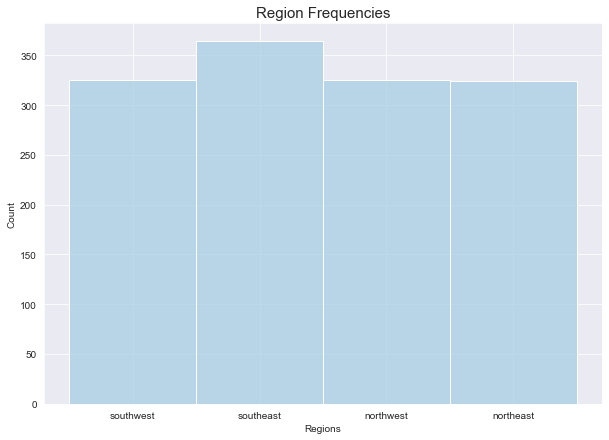

In [15]:
#Frequences of region
plt.figure(figsize = (10,7))
sns.histplot(Insurance_df['region'], bins=4);
plt.xlabel('Regions')
plt.ylabel('Count')
plt.title('Region Frequencies', fontsize= 15);

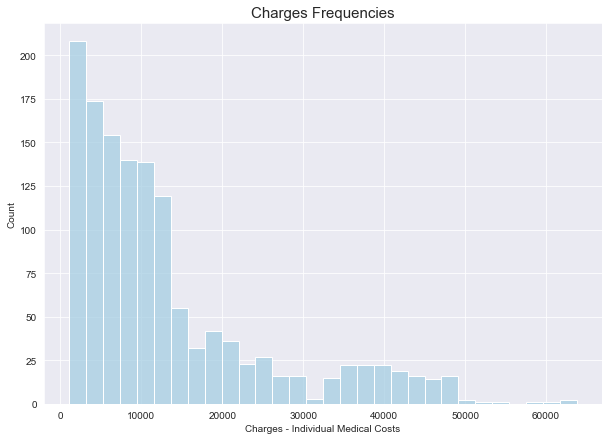

In [16]:
#Frequencies of charges
plt.figure(figsize = (10,7))
sns.histplot(Insurance_df['charges']);
plt.xlabel('Charges - Individual Medical Costs')
plt.ylabel('Count')
plt.title('Charges Frequencies', fontsize= 15);

An argument may be made to remove the anomolous charges (around 30000, then again above 50000). However, further exploratory analysis will be required to determine if these outliers should be removed.

In [17]:
Insurance_df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

## 3. Exploratory Data Analysis

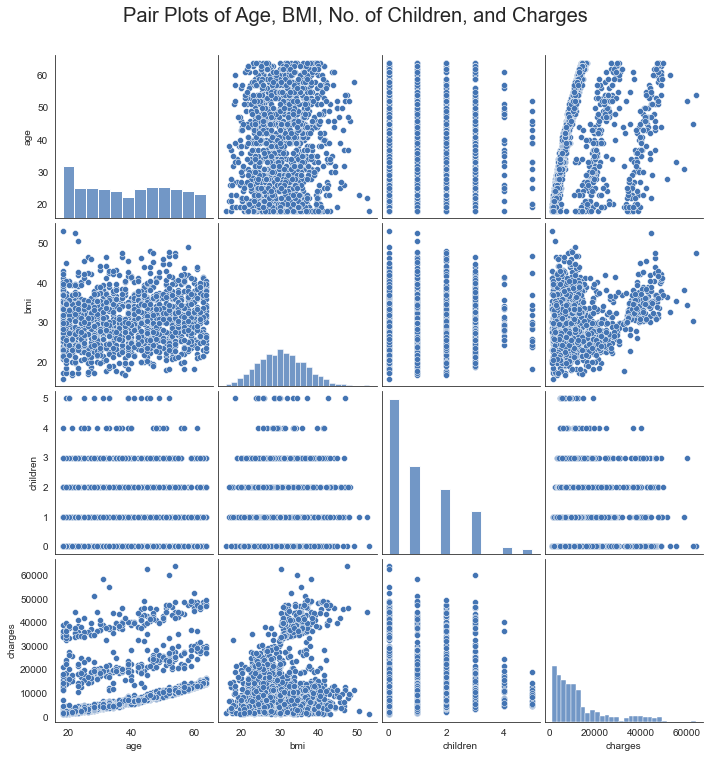

In [18]:
# Pair plot with all continuous data
colors = ["#4374B3", "#FF0B04"]
sns.set_palette(sns.color_palette(colors))
sns.set_style('white')
#sns.set_palette('tab10')
sns.pairplot(Insurance_df, vars=['age','bmi', 'children', 'charges'])
plt.suptitle('Pair Plots of Age, BMI, No. of Children, and Charges', size= 20, y=1.05);

There appears to be a positive correlation between age vs charges & bmi vs charges. Note that there are 3 distinct bands in the age vs charges plot, all of which indicate to have a positive correlation.

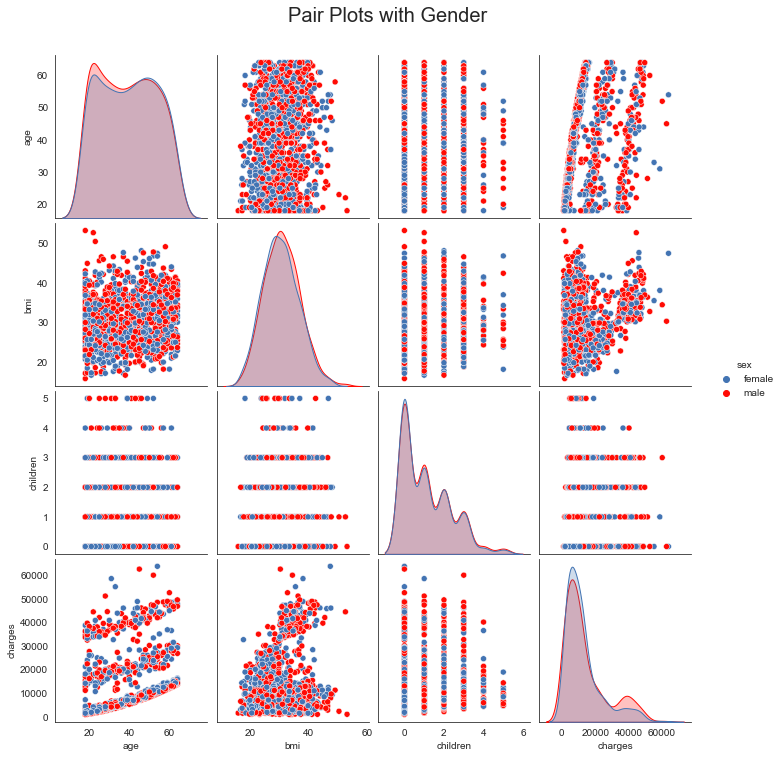

In [19]:
# Add in some of the categorical data as hues, starting with sex
sns.pairplot(Insurance_df, vars=['age','bmi', 'children', 'charges'], hue='sex')
plt.suptitle('Pair Plots with Gender', size= 20, y=1.05);

Based on the above pairplot, there appears to be a fairly even distribution of gender across age, bmi, and children i.e. one gender does not appear to have higher or lower charges for each of the variables. However, perhaps noteworthy is that the lowest band of the age group appears to have more women than men.

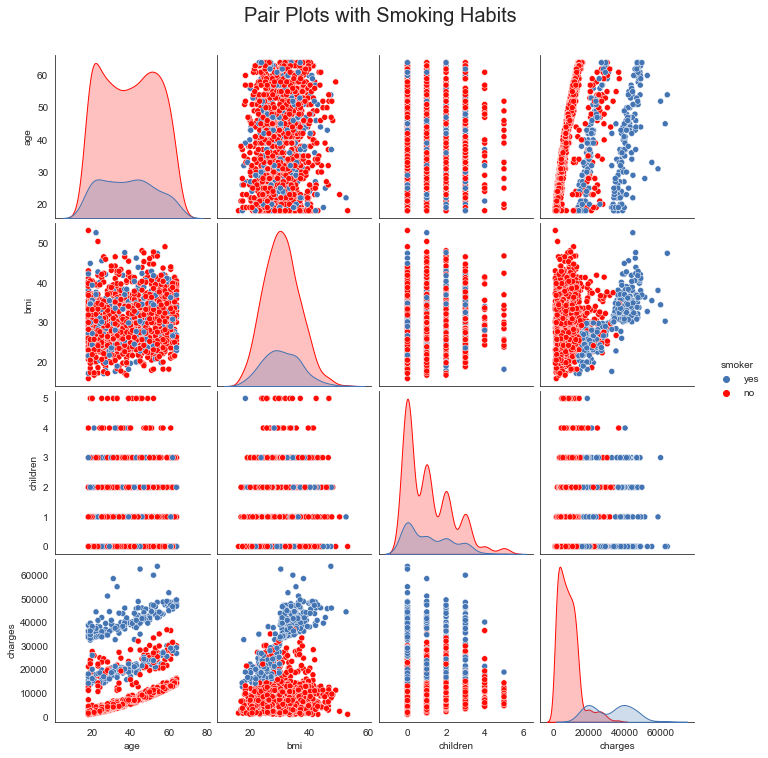

In [20]:
# Compare smoker vs non-smoker
sns.pairplot(Insurance_df, vars=['age','bmi', 'children', 'charges'], hue='smoker')
plt.suptitle('Pair Plots with Smoking Habits', size= 20, y=1.05);

Smoker vs non-smoker appears to have a big impact on the plots. There  is definitely a correlation between smoking and charges (with smoking leading to higher charges). Also interesting to see the split in the age vs charges & age vs bmi graphs.

* Age vs Charges for Smokers vs Non-Smokers
    * Smokers only fall into the upper 2 bands for the age vs charges plot
    * Non-smokers only fall into the lower 2 bands
 
 
* BMI vs Charges for Smokers vs Non-Smokers
    * No clear correlation between BMI & Charges for non-smokers
    * However, there appears to be a clear correlation between BMI & Charges for smokers

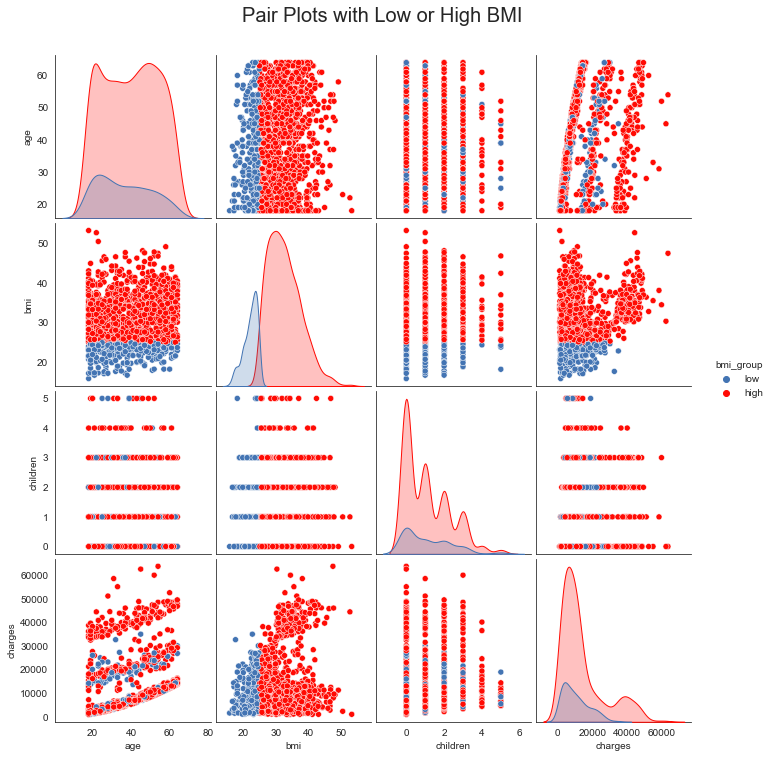

In [21]:
# Compare low vs high BMI
sns.pairplot(Insurance_df, vars=['age','bmi', 'children', 'charges'], hue='bmi_group')
plt.suptitle('Pair Plots with Low or High BMI', size= 20, y=1.05);

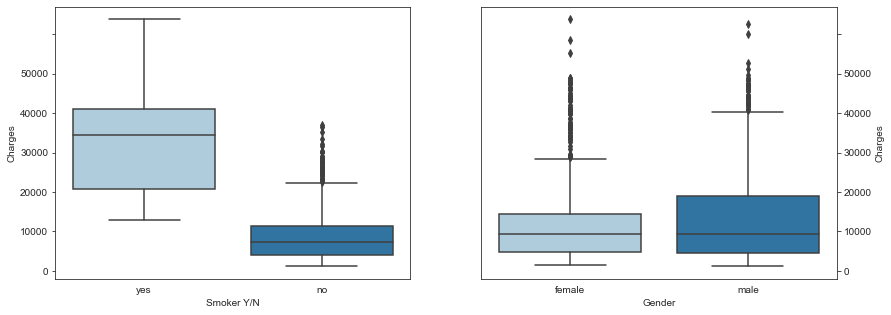

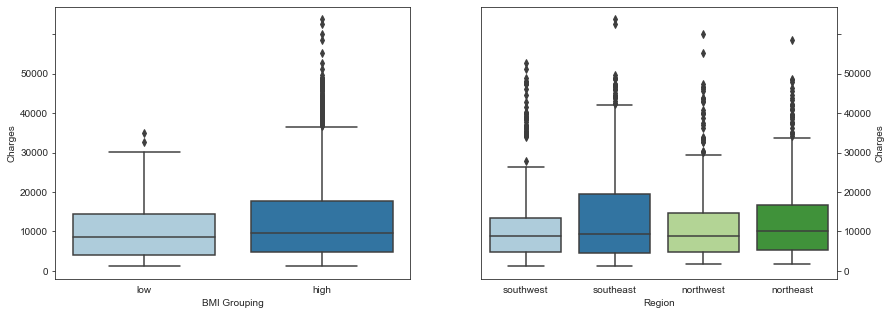

In [22]:
# Boxplot for smoker, gender, region, and bmi group
sns.set_palette('Paired')
f, axes = plt.subplots(1, 2,figsize=(14,5))
sns.boxplot(x=Insurance_df['smoker'],y=Insurance_df['charges'], ax=axes[0])
sns.boxplot(x=Insurance_df['sex'],y=Insurance_df['charges'], ax=axes[1])
#sns.despine(left=True, bottom=True)
yticklabels = np.arange(0, 60000, 10000).tolist()
yticklabels.insert(0, 0)

axes[0].set_yticklabels(yticklabels)
axes[0].set(xlabel='Smoker Y/N', ylabel='Charges')
axes[0].yaxis.tick_left()
#axes[0].sns.despine(right=True, top=True)

axes[1].set_yticklabels(yticklabels)
axes[1].set(xlabel='Gender', ylabel='Charges')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

f, axes = plt.subplots(1, 2,figsize=(14,5))
sns.boxplot(x=Insurance_df['bmi_group'],y=Insurance_df['charges'], ax=axes[0])
sns.boxplot(x=Insurance_df['region'],y=Insurance_df['charges'], ax=axes[1])
#sns.despine(left=True, bottom=True)
yticklabels = np.arange(0, 60000, 10000).tolist()
yticklabels.insert(0, 0)

axes[0].set_yticklabels(yticklabels)
axes[0].set(xlabel='BMI Grouping', ylabel='Charges')
axes[0].yaxis.tick_left()
#axes[0].sns.despine(right=True, top=True)

axes[1].set_yticklabels(yticklabels)
axes[1].set(xlabel='Region', ylabel='Charges')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right();



Mean, STD, 75% & max are all higher for Southeast, though median is equivalent to other regions. The below data table suggests that age is equivalent between all the regions.

In [23]:
# Based on boxplots, Southeast region appears to have more deviation in charges
Insurance_df.groupby('region')['charges'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
northeast,324.0,13406.384516,11255.803066,1694.7964,5194.322288,10057.652025,16687.3641,58571.07448
northwest,325.0,12417.575374,11072.276928,1621.3402,4719.736550,8965.795750,14711.7438,60021.39897
southeast,364.0,14735.411438,13971.098589,1121.8739,4440.886200,9294.131950,19526.2869,63770.42801
southwest,325.0,12346.937377,11557.179101,1241.5650,4751.070000,8798.593000,13462.5200,52590.82939


In [24]:
Insurance_df.groupby('region')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
northeast,324.0,39.268519,14.069007,18.0,27.00,39.5,51.0,64.0
northwest,325.0,39.196923,14.051646,19.0,26.00,39.0,51.0,64.0
southeast,364.0,38.939560,14.164585,18.0,26.75,39.0,51.0,64.0
southwest,325.0,39.455385,13.959886,19.0,27.00,39.0,51.0,64.0


In [25]:
Insurance_df.groupby('bmi_group')['charges'].describe()

,count,mean,std,min,25%,50%,75%,max
bmi_group,,,,,,,,
low,247.0,10284.290025,7494.493965,1121.8739,3933.316075,8582.3023,14513.767425,35069.37452
high,1091.0,13946.476035,12834.725537,1131.5066,4889.518150,9563.0290,17654.442975,63770.42801


### Correlation Matrix

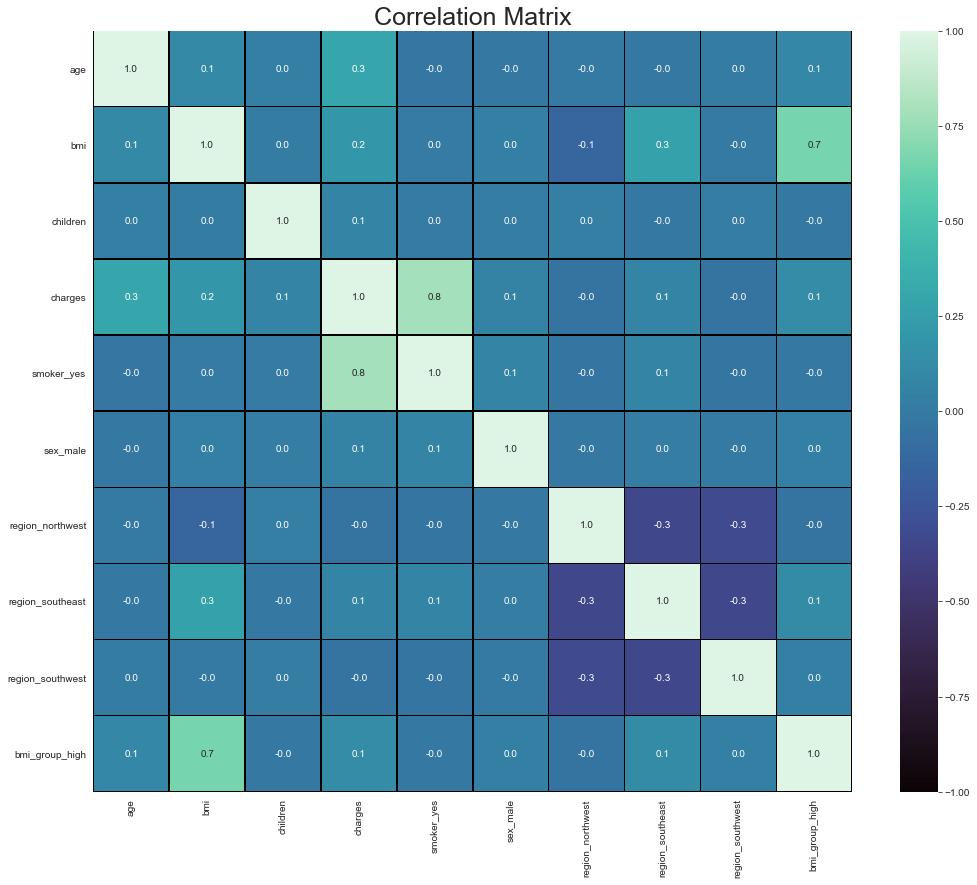

In [26]:
# Correlation Matrix
plt.subplots(figsize=(17,14))
sns.heatmap(Insurance_df.corr(), cmap = 'mako', vmin=-1, vmax=1, annot=True, linewidths=0.5, linecolor="Black", fmt="1.1f")
plt.title("Correlation Matrix",fontsize=25)
plt.show()

## 4. Hypothesis Testing

### Smokers vs Non-Smoker

Based on the EDA, smoking habit appears to be the variable with the biggest influence on charges. In order to confirm our findings, a 2-sample t-test can be run to determine if there is a statistically significant difference between the mean charges of smokers and non-smokers.

Additionally, while both age and BMI seem to only have a small influence on the data population as a whole, they may have a larger influence on just the smoker population. Therefore, an analysis will be conducted to determine if there is a relationship between age or BMI on the smoker only population.

Based on our EDA, smoking habit appears to be the variable with the biggest influence on charges. Therefore, the first hypothesis test is as follows:

H0: There is no significant difference in the charges between smokers and non-smokers.

H1: There is a significant difference in the charges between the smokers and non-smokers.

In [27]:
#split the dataset into non-smoker and smoker and compare the means of both datasets using a 2-sample t-test
df_smoker = Insurance_df[Insurance_df['smoker'] == 'yes']
df_nonsmoker = Insurance_df[Insurance_df['smoker'] == 'no']
df_smoker.count()

age                 274
sex                 274
bmi                 274
children            274
smoker              274
region              274
charges             274
smoker_yes          274
sex_male            274
region_northwest    274
region_southeast    274
region_southwest    274
bmi_group           274
bmi_group_high      274
dtype: int64

In [28]:
df_nonsmoker.count()

age                 1064
sex                 1064
bmi                 1064
children            1064
smoker              1064
region              1064
charges             1064
smoker_yes          1064
sex_male            1064
region_northwest    1064
region_southeast    1064
region_southwest    1064
bmi_group           1064
bmi_group_high      1064
dtype: int64

One of the assumptions of a valid t test is that the sample sizes of both groups are of equal size. Because of the discrepency between the number of values in each dataset, a random selection of non-smoker values will be selected to run the t-test with and the p-values will be compared.

In [29]:
#Select 274 randomly selected non-smokers for comparisons
df_Rnonsmoker = df_nonsmoker.sample(n=274)
df_Rnonsmoker.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 110 to 25
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               274 non-null    int64   
 1   sex               274 non-null    object  
 2   bmi               274 non-null    float64 
 3   children          274 non-null    int64   
 4   smoker            274 non-null    object  
 5   region            274 non-null    object  
 6   charges           274 non-null    float64 
 7   smoker_yes        274 non-null    uint8   
 8   sex_male          274 non-null    uint8   
 9   region_northwest  274 non-null    uint8   
 10  region_southeast  274 non-null    uint8   
 11  region_southwest  274 non-null    uint8   
 12  bmi_group         274 non-null    category
 13  bmi_group_high    274 non-null    uint8   
dtypes: category(1), float64(2), int64(2), object(3), uint8(6)
memory usage: 19.1+ KB


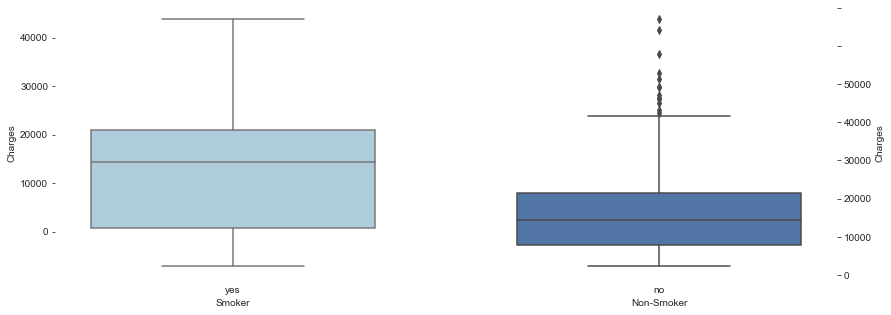

In [30]:
# Boxplot for smoker, non-smoker
f, axes = plt.subplots(1, 2,figsize=(14,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df_smoker['smoker'],y=df_smoker['charges'], ax=axes[0])
sns.boxplot(x=df_Rnonsmoker['smoker'],y=df_Rnonsmoker['charges'], ax=axes[1], color='#4374B3')
yticklabels = np.arange(0, 60000, 10000).tolist()
yticklabels.insert(0, 0)

axes[0].set_yticklabels(yticklabels)
axes[0].set(xlabel='Smoker', ylabel='Charges')
axes[0].yaxis.tick_left()

axes[1].set_yticklabels(yticklabels)
axes[1].set(xlabel='Non-Smoker', ylabel='Charges')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

In [31]:
df_smoker['charges'].describe()

count      274.000000
mean     32050.231832
std      11541.547176
min      12829.455100
25%      20826.244213
50%      34456.348450
75%      41019.207275
max      63770.428010
Name: charges, dtype: float64

In [32]:
df_Rnonsmoker['charges'].describe()

count      274.000000
mean      8220.525464
std       5633.425095
min       1131.506600
25%       3953.791000
50%       7226.652700
75%      10795.992150
max      33471.971890
Name: charges, dtype: float64

Both the boxplot and the table appear to indicate that the charge mean and distribution are not similar between smokers and non-smokers. To confirm if these variances are statistically significant, a two-sample t-test will be run.

In [33]:
smoker_test=df_smoker.charges
smoker_test

0       16884.92400
11      27808.72510
14      39611.75770
19      36837.46700
23      37701.87680
           ...     
1313    36397.57600
1314    18765.87545
1321    28101.33305
1323    43896.37630
1337    29141.36030
Name: charges, Length: 274, dtype: float64

In [34]:
Rnonsmoker_test=df_Rnonsmoker.charges
Rnonsmoker_test

110     10825.25370
698     10976.24575
1154    11015.17470
382     20781.48892
1009     9957.72160
           ...     
483      9880.06800
1088     9748.91060
118      8601.32930
17       2395.17155
25      14001.13380
Name: charges, Length: 274, dtype: float64

In [35]:
stats.ttest_ind(smoker_test, Rnonsmoker_test)

Ttest_indResult(statistic=30.71335820086328, pvalue=4.575943930629588e-121)

#### The p-value is extremely small, indicating that we reject the null hypothesis that there is no difference in charges between smokers and non-smokers.

### Low BMI vs High BMI

The EDA showed that BMI had a low influence on charges. However, a quick hypothesis test will be conducted to confirm these findings. The, the first hypothesis test is as follows:

H0: There is no significant difference in the charges between claimants with a low BMI and claimants with a high BMI.

H1: There is a significant difference in the charges between claimants with a low BMI and claimants with a high BMI.

In [36]:
#split the dataset into low and high BMI and compare the means of both datasets using a 2-sample t-test
#high_bmi = Insurance_df.loc[Insurance_df['bmi'] >= 25] has already been defined
low_bmi = Insurance_df.loc[Insurance_df['bmi'] < 25]

In [37]:
high_bmi.count()

age                 1093
sex                 1093
bmi                 1093
children            1093
smoker              1093
region              1093
charges             1093
smoker_yes          1093
sex_male            1093
region_northwest    1093
region_southeast    1093
region_southwest    1093
bmi_group           1093
bmi_group_high      1093
dtype: int64

In [38]:
low_bmi.count()

age                 245
sex                 245
bmi                 245
children            245
smoker              245
region              245
charges             245
smoker_yes          245
sex_male            245
region_northwest    245
region_southeast    245
region_southwest    245
bmi_group           245
bmi_group_high      245
dtype: int64

In [39]:
#Select 245 randomly selected high BMI for comparisons
Rhigh_BMI = high_bmi.sample(n=245)
Rhigh_BMI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 1289 to 59
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               245 non-null    int64   
 1   sex               245 non-null    object  
 2   bmi               245 non-null    float64 
 3   children          245 non-null    int64   
 4   smoker            245 non-null    object  
 5   region            245 non-null    object  
 6   charges           245 non-null    float64 
 7   smoker_yes        245 non-null    uint8   
 8   sex_male          245 non-null    uint8   
 9   region_northwest  245 non-null    uint8   
 10  region_southeast  245 non-null    uint8   
 11  region_southwest  245 non-null    uint8   
 12  bmi_group         245 non-null    category
 13  bmi_group_high    245 non-null    uint8   
dtypes: category(1), float64(2), int64(2), object(3), uint8(6)
memory usage: 17.1+ KB


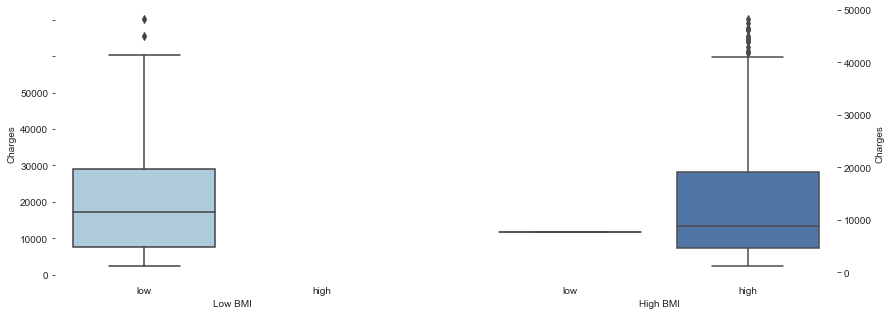

In [40]:
# Boxplot for low BMI, high BMI
f, axes = plt.subplots(1, 2,figsize=(14,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=low_bmi['bmi_group'],y=low_bmi['charges'], ax=axes[0])
sns.boxplot(x=Rhigh_BMI['bmi_group'],y=Rhigh_BMI['charges'], ax=axes[1], color='#4374B3')
yticklabels = np.arange(0, 60000, 10000).tolist()
yticklabels.insert(0, 0)

axes[0].set_yticklabels(yticklabels)
axes[0].set(xlabel='Low BMI', ylabel='Charges')
axes[0].yaxis.tick_left()

axes[1].set_yticklabels(yticklabels)
axes[1].set(xlabel='High BMI', ylabel='Charges')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

In [41]:
low_bmi['charges'].describe()

count      245.000000
mean     10282.224474
std       7520.485850
min       1121.873900
25%       3861.209650
50%       8582.302300
75%      14571.890800
max      35069.374520
Name: charges, dtype: float64

In [42]:
Rhigh_BMI['charges'].describe()

count      245.000000
mean     13836.269896
std      12902.737991
min       1137.011000
25%       4667.607650
50%       8823.985750
75%      19107.779600
max      48173.361000
Name: charges, dtype: float64

Both the boxplot and the table appear to indicate that the charge mean and distribution are not similar between claimants with a low BMI and high BMI. To confirm if these variances are statistically significant, a two-sample t-test will be run.

In [43]:
lowBMI_test=low_bmi.charges
lowBMI_test

3       21984.47061
15       1837.23700
17       2395.17155
26      14451.83515
28       2775.19215
           ...     
1304    21259.37795
1306    16115.30450
1314    18765.87545
1316     1731.67700
1328    22395.74424
Name: charges, Length: 245, dtype: float64

In [44]:
RhighBMI_test = Rhigh_BMI.charges
RhighBMI_test

1289     7147.47280
1081     4454.40265
988      4518.82625
1252    16232.84700
704      8930.93455
           ...     
316      8835.26495
715     12146.97100
749      3062.50825
1093    33907.54800
59       5989.52365
Name: charges, Length: 245, dtype: float64

In [45]:
stats.ttest_ind(lowBMI_test, RhighBMI_test)

Ttest_indResult(statistic=-3.724913905993178, pvalue=0.0002182078373250537)

The p-value is extremely small, indicating that we reject the null hypothesis that there is no significant difference in the charges between claimants with a low BMI and claimants with a high BMI.

### Age

Based on the EDA, charges by age falls into distinct bands. The smoker population is distributed the top 2 bands. In order to determine the influence on mean charges by age, these 2 bands will be used to define 2 different population groups and a 2-sample t-test will be run. Therefore, our second hypothesis test will therefore look at the influence of age on smokers:

H0: There is no significant difference in the mean ages of lower charge group of smokers and the higher charge group of smokers 

H1: There is a significant difference in the mean ages of the lower charge group of smokers and the higher charge group of smokers

In [46]:
#Create a new smoking only dataset and review the distribution of ages
df_SM = Insurance_df.query('smoker == ["yes"]')
df_SM.count()

age                 274
sex                 274
bmi                 274
children            274
smoker              274
region              274
charges             274
smoker_yes          274
sex_male            274
region_northwest    274
region_southeast    274
region_southwest    274
bmi_group           274
bmi_group_high      274
dtype: int64

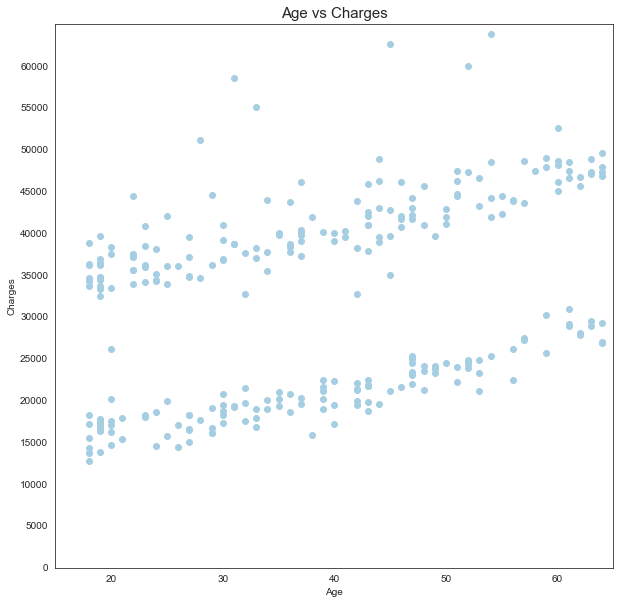

In [47]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(df_SM['age'], df_SM['charges'])
plt.yticks(np.arange(0, 65000, 5000))
plt.xlim(15, 65)
plt.ylim(0, 65000)
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Age vs Charges', fontsize = 15)
plt.show();

In [48]:
def charge_group(charge):
    bucket = 0
    
    if charge < 30000:
        bucket = 'low'
    
    elif charge >= 30000:
        bucket = 'high'
    return bucket 

In [49]:
df_SM['charge_group'] = df_SM['charges'].apply(charge_group)
df_SM.head()

<ipython-input-49-9b15cc1f7ac3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SM['charge_group'] = df_SM['charges'].apply(charge_group)


,age,sex,bmi,children,smoker,region,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest,bmi_group,bmi_group_high,charge_group
0,19,female,27.90,0,yes,southwest,16884.9240,1,0,0,0,1,high,1,low
11,62,female,26.29,0,yes,southeast,27808.7251,1,0,0,1,0,high,1,low
14,27,male,42.13,0,yes,southeast,39611.7577,1,1,0,1,0,high,1,high
19,30,male,35.30,0,yes,southwest,36837.4670,1,1,0,0,1,high,1,high
23,34,female,31.92,1,yes,northeast,37701.8768,1,0,0,0,0,high,1,high


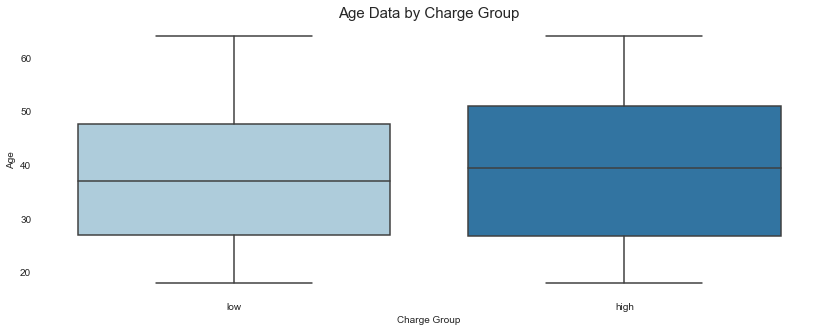

In [50]:
#Visual review of the 2 charges groups to assess the distribution of the data within each
f, axe = plt.subplots(1, 1,figsize=(14,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df_SM['charge_group'],y=df_SM['age'], ax=axe)
axe.set(xlabel='Charge Group', ylabel='Age')
plt.title('Age Data by Charge Group', fontsize = 15);

In [51]:
df_SM.groupby('charge_group')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
charge_group,,,,,,,,
high,152.0,39.335526,14.260093,18.0,26.75,39.5,51.00,64.0
low,122.0,37.491803,13.479857,18.0,27.00,37.0,47.75,64.0


Both the boxplot and the table appear to indicate that the age mean and distribution are similar for both the Lower Charge group and the Higher Charge group, although the mean age for the higher charge group is slightly higher with a slightly bigger distribution. To determine if these variances are statistically significant, a two-sample t-test will be run.

In [52]:
df_lowcharge=df_SM.loc[df_SM['charges'] < 30000]['age']
df_lowcharge

0       19
11      62
52      48
58      53
64      20
        ..
1306    29
1307    32
1314    30
1321    62
1337    61
Name: age, Length: 122, dtype: int64

In [53]:
df_highcharge=df_SM.loc[df_SM['charges'] >= 30000]['age']
df_highcharge

14      27
19      30
23      34
29      31
30      22
        ..
1301    62
1303    43
1308    25
1313    19
1323    42
Name: age, Length: 152, dtype: int64

In [54]:
#Run the 2-sample t-test comparing mean ages of individuals between the high charge group and the low charge group
stats.ttest_ind(df_lowcharge, df_highcharge)

Ttest_indResult(statistic=-1.0897644959588435, pvalue=0.27678141074928714)

#### The p-value is somewhat high, indicating that we fail to reject the null hypothesis that there is no difference in mean ages of the lower charge group and the higher charge group.

### BMI as Continuous Variable

Based on the initial EDA, BMI appears to influence the charges of smokers. However, the variable is more appropriately analyzed using linear regression. A quick analysis of BMI for the smokers only population, as well as with the charge groups used in the Age analysis, will be conducted in order to test this assertion.

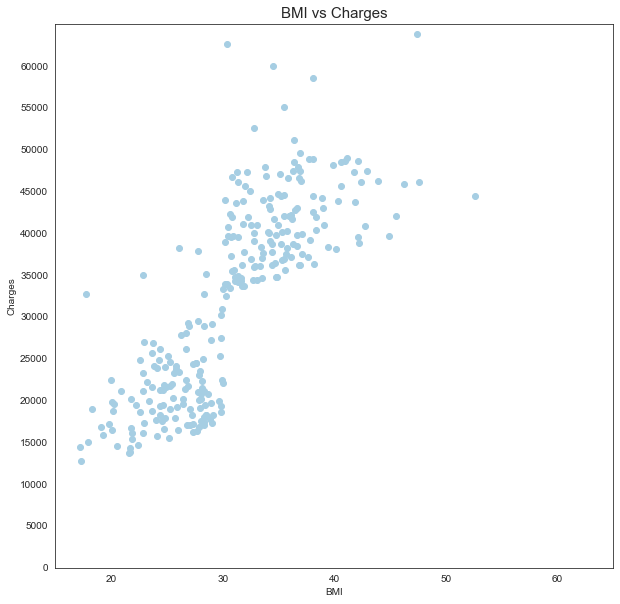

In [55]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(df_SM['bmi'], df_SM['charges'])
plt.yticks(np.arange(0, 65000, 5000))
plt.xlim(15, 65)
plt.ylim(0, 65000)
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('BMI vs Charges', fontsize = 15)
plt.show();

Charges by BMI does not reveal the obvious bands of charges that the age variable did.

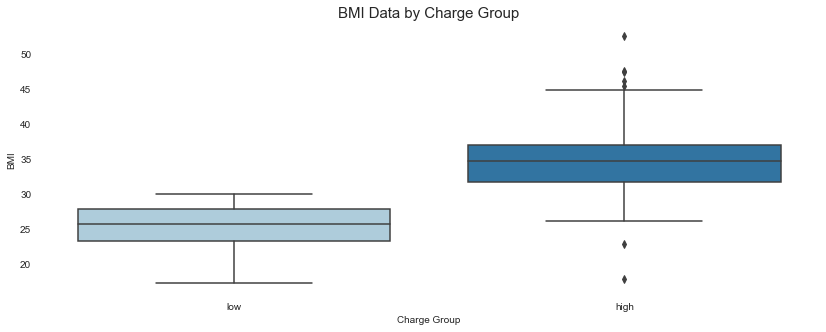

In [56]:
#As a validation, visual review of the 2 charges groups to assess the distribution of the data within each group

f, axe = plt.subplots(1, 1,figsize=(14,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df_SM['charge_group'],y=df_SM['bmi'], ax=axe)
axe.set(xlabel='Charge Group', ylabel='BMI')
plt.title('BMI Data by Charge Group', fontsize = 15);

In [57]:
df_SM.groupby('charge_group')['bmi'].describe()

,count,mean,std,min,25%,50%,75%,max
charge_group,,,,,,,,
high,152.0,35.062730,4.647097,17.765,31.775,34.75,37.05500,52.58
low,122.0,25.283443,3.104577,17.195,23.250,25.65,27.88375,30.00


Both the boxplot and the table appear to indicate that the age mean and distribution are not very similar for the Lower Charge group and the Higher Charge group. Therefore, 2 data sets are not a good basis for the 2-sample t-test.

In lieu of the 2-sample t-test, ANOVA testing will be conducted to determine if we can test the following hypothesis:

H0: There is no difference between mean of BMI bewteen insurance charge higher than 30000 and less than 30000

H1: There is significant difference between mean of BMI bewteen insurance charge higher than 30000 and less than 30000

In [58]:
mod = ols('bmi ~ charge_group',
                data=df_SM).fit()
                
aov_table = stm.stats.anova_lm(mod, typ=2)
print(aov_table)  

                   sum_sq     df           F        PR(>F)
charge_group  6472.429020    1.0  397.658484  3.816475e-55
Residual      4427.167446  272.0         NaN           NaN


The BMI means were tested using ANOVA. The F value is significately high which indicates that the mean is different. H0 is rejected.

### BMI as Categorical Variable

Another approach to determining whether BMI has an influence on the charges of smoker claimants is to treat BMI as a categorical variable. Therefore, the third hypothesis test is as follows:

H0: There is no significant difference in the charges between smokers with a low BMI and a high BMI.

H1: There is a significant difference in the charges between the smokers with a low BMI and a high BMI.

In [59]:
#Divide the smoker dataframe into low and high BMI groups and compare the means of both datasets using a 2-sample t-test 
df_lowBMI = df_SM[df_SM['bmi_group'] == 'low']
df_highBMI = df_SM[df_SM['bmi_group'] == 'high']
df_lowBMI.count()

age                 55
sex                 55
bmi                 55
children            55
smoker              55
region              55
charges             55
smoker_yes          55
sex_male            55
region_northwest    55
region_southeast    55
region_southwest    55
bmi_group           55
bmi_group_high      55
charge_group        55
dtype: int64

In [60]:
#Select 55 high BMI claimants to compare with the 55 low BMI claimants
df_RhighBMI = df_highBMI.sample(n=55)
df_RhighBMI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 420 to 256
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               55 non-null     int64   
 1   sex               55 non-null     object  
 2   bmi               55 non-null     float64 
 3   children          55 non-null     int64   
 4   smoker            55 non-null     object  
 5   region            55 non-null     object  
 6   charges           55 non-null     float64 
 7   smoker_yes        55 non-null     uint8   
 8   sex_male          55 non-null     uint8   
 9   region_northwest  55 non-null     uint8   
 10  region_southeast  55 non-null     uint8   
 11  region_southwest  55 non-null     uint8   
 12  bmi_group         55 non-null     category
 13  bmi_group_high    55 non-null     uint8   
 14  charge_group      55 non-null     object  
dtypes: category(1), float64(2), int64(2), object(4), uint8(6)
memory usage: 4

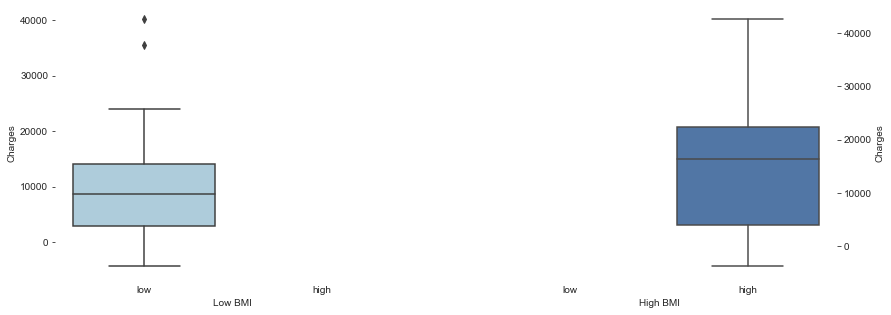

In [61]:
# Boxplot for smoker low BMI vs smoker high BMI
f, axes = plt.subplots(1, 2,figsize=(14,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df_lowBMI['bmi_group'],y=df_lowBMI['charges'], ax=axes[0])
sns.boxplot(x=df_RhighBMI['bmi_group'],y=df_RhighBMI['charges'], ax=axes[1], color='#4374B3')
yticklabels = np.arange(0, 60000, 10000).tolist()
yticklabels.insert(0, 0)

axes[0].set_yticklabels(yticklabels)
axes[0].set(xlabel='Low BMI', ylabel='Charges')
axes[0].yaxis.tick_left()

axes[1].set_yticklabels(yticklabels)
axes[1].set(xlabel='High BMI', ylabel='Charges')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

In [62]:
lowBMI_test=df_lowBMI.charges
lowBMI_test.head()

58    23244.79020
64    14711.74380
69    17663.14420
70    16577.77950
85    21098.55405
Name: charges, dtype: float64

In [63]:
RhighBMI_test=df_RhighBMI.charges
RhighBMI_test.head()

420    46889.26120
297    21978.67690
207    20984.09360
818    23401.30575
956    41999.52000
Name: charges, dtype: float64

In [64]:
#Run the 2-sample t-test comparing mean charge of smokers with low BMI vs smokers with high BMI
stats.ttest_ind(RhighBMI_test, lowBMI_test)

Ttest_indResult(statistic=8.938816756070207, pvalue=1.1946917643715751e-14)

The p-value is very low, indicating that we reject the null hypothesis that there is no significant difference in the charges between smokers with a low BMI and a high BMI.

 ## 5. Linear Regression

Linear Regression will be used to determine the relationship of all the variables with charges.

In [65]:
Insurance_df = Insurance_df.drop(['smoker', 'sex', 'region'], axis=1)

In [66]:
Insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               1338 non-null   int64   
 1   bmi               1338 non-null   float64 
 2   children          1338 non-null   int64   
 3   charges           1338 non-null   float64 
 4   smoker_yes        1338 non-null   uint8   
 5   sex_male          1338 non-null   uint8   
 6   region_northwest  1338 non-null   uint8   
 7   region_southeast  1338 non-null   uint8   
 8   region_southwest  1338 non-null   uint8   
 9   bmi_group         1338 non-null   category
 10  bmi_group_high    1338 non-null   uint8   
dtypes: category(1), float64(2), int64(2), uint8(6)
memory usage: 51.2 KB


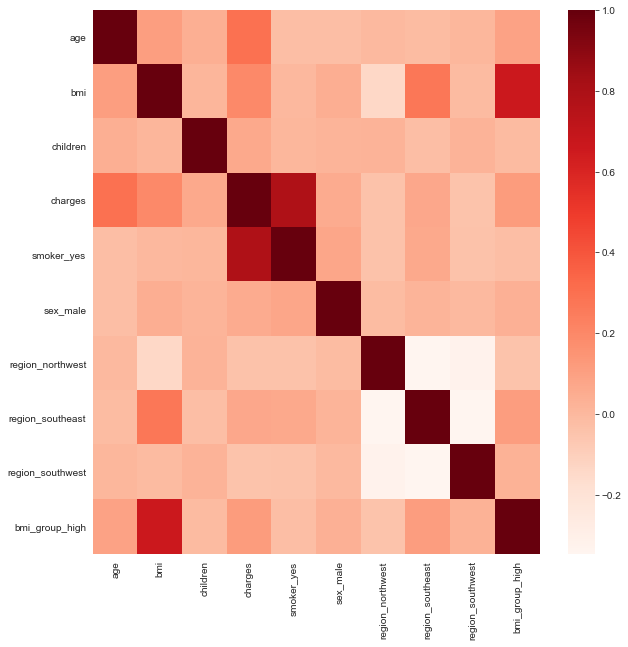

In [67]:
# Show correlation plot of all variables
sns.heatmap(data=Insurance_df.corr(method='pearson'), cmap="Reds");

The correlation plot shows that there is not much correlation between the majority of the independent variables. The main variables to keep an eye on when running the regression are and BMI & region (BMI is slightly correlated with the North-West & South-East regions).

In [68]:
# Convert the binary variables to 'Category' type
Insurance_df[['smoker_yes', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']] = Insurance_df[['smoker_yes', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']].astype('category')

In [69]:
# Create a function to run the OLS linear regression for varying input variables
def ols_analysis(df, x, y):
    comp = y + ' ~ ' + x
    results = sm.ols(formula=comp, data=df).fit()
    return results

In [70]:
# Create a function to run through combinations of independent variables & print a summary table of the respective R-Square values
# Function can be run for all indepenedent variables individually, and then repeated whilst keeping the best-looking variable(s)
def fwd_sel_regression(df, dep_variable, all_ind_variables, keep_var):
    # Create a new list that has the kept variables removed (if no variables are kept then will run through the entire list of independent variables)
    rem_variables = list(all_ind_variables)
    for i in range(len(keep_var)):
        rem_variables.remove(keep_var[i])
    
    # Reset the R-Squared table to just the headers row
    r_squared = [["Independent Variable(s)","R-Squared"]]
    # Loop through each combination of kept variables & remaining independent variables, & run the regression model for each combination
    for i in range(len(rem_variables)):
        model_variables = ' + '.join(keep_var+rem_variables[i:i+1])
        results = ols_analysis(df, model_variables, dep_variable)
        # Add the r-squared output to the r-square table
        r_squared.append([' + '.join(keep_var+rem_variables[i:i+1]), '%.3f' % results.rsquared])

    #Print the R-Squared results
    print('\n\033[1mR-Squared values for the independent variables\033[0m')
    print(tabulate(r_squared,tablefmt="fancy_grid", headers="firstrow"))

In [71]:
# Set the dependent & independent variables
dep_variable = 'charges'
all_ind_variables  = ['age', 'bmi', 'children', 'smoker_yes', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']

In [72]:
# Run the model for all the independent variables individually
fwd_sel_regression(Insurance_df, dep_variable, all_ind_variables, [])


R-Squared values for the independent variables
╒═══════════════════════════╤═════════════╕
│ Independent Variable(s)   │   R-Squared │
╞═══════════════════════════╪═════════════╡
│ age                       │       0.089 │
├───────────────────────────┼─────────────┤
│ bmi                       │       0.039 │
├───────────────────────────┼─────────────┤
│ children                  │       0.005 │
├───────────────────────────┼─────────────┤
│ smoker_yes                │       0.62  │
├───────────────────────────┼─────────────┤
│ sex_male                  │       0.003 │
├───────────────────────────┼─────────────┤
│ region_northwest          │       0.002 │
├───────────────────────────┼─────────────┤
│ region_southeast          │       0.005 │
├───────────────────────────┼─────────────┤
│ region_southwest          │       0.002 │
╘═══════════════════════════╧═════════════╛


The linear regression model clearly shows that the 'smoker_yes' variable has the largest impact on the 'charges' dependent variable. The R-Squared value is much larger (0.62) than for any of the other indepenedent variables. We therefore select the 'smoker_yes' variable to take forward to the next stage of the model analysis.

In [73]:
# Run the model for the 'smoker_yes' variable, combined with each of the remaining independent variables
fwd_sel_regression(Insurance_df, dep_variable, all_ind_variables, ['smoker_yes'])


R-Squared values for the independent variables
╒═══════════════════════════════╤═════════════╕
│ Independent Variable(s)       │   R-Squared │
╞═══════════════════════════════╪═════════════╡
│ smoker_yes + age              │       0.721 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + bmi              │       0.658 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + children         │       0.624 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + sex_male         │       0.62  │
├───────────────────────────────┼─────────────┤
│ smoker_yes + region_northwest │       0.62  │
├───────────────────────────────┼─────────────┤
│ smoker_yes + region_southeast │       0.62  │
├───────────────────────────────┼─────────────┤
│ smoker_yes + region_southwest │       0.62  │
╘═══════════════════════════════╧═════════════╛


This next step of the analysis shows that the 'age' variable has the greatest impact on R-Squared, increasing from 0.62 to 0.721. We therefore take this forward to the next step, along with the 'smoker_yes' variable.

In [74]:
# Run the model for the 'smoker_yes' & 'age' variables, combined with each of the remaining independent variables
fwd_sel_regression(Insurance_df, dep_variable, all_ind_variables, ['smoker_yes', 'age'])


R-Squared values for the independent variables
╒═════════════════════════════════════╤═════════════╕
│ Independent Variable(s)             │   R-Squared │
╞═════════════════════════════════════╪═════════════╡
│ smoker_yes + age + bmi              │       0.747 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + children         │       0.724 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + sex_male         │       0.721 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + region_northwest │       0.722 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + region_southeast │       0.722 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + region_southwest │       0.722 │
╘═════════════════════════════════════╧═════════════╛


The next variable we add to the model is 'bmi', which increase R-Squared from 0.721 to 0.747.

In [75]:
# Run the model for the 'smoker_yes', 'age' & 'bmi' variables, combined with each of the remaining independent variables
fwd_sel_regression(Insurance_df, dep_variable, all_ind_variables, ['smoker_yes', 'age', 'bmi'])


R-Squared values for the independent variables
╒═══════════════════════════════════════════╤═════════════╕
│ Independent Variable(s)                   │   R-Squared │
╞═══════════════════════════════════════════╪═════════════╡
│ smoker_yes + age + bmi + children         │       0.75  │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + sex_male         │       0.747 │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + region_northwest │       0.748 │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + region_southeast │       0.748 │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + region_southwest │       0.748 │
╘═══════════════════════════════════════════╧═════════════╛


At this step, the increases in R-Squared are very minor. The maximum increase in R-Squared is for the 'children' variable, which only increases R-Squared from 0.747 to 0.750.

In [76]:
# Run the model for the 'smoker_yes', 'age', 'bmi' & 'children' variables, combined with each of the remaining independent variables
fwd_sel_regression(Insurance_df, dep_variable, all_ind_variables, ['smoker_yes', 'age', 'bmi', 'children'])


R-Squared values for the independent variables
╒══════════════════════════════════════════════════════╤═════════════╕
│ Independent Variable(s)                              │   R-Squared │
╞══════════════════════════════════════════════════════╪═════════════╡
│ smoker_yes + age + bmi + children + sex_male         │        0.75 │
├──────────────────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + children + region_northwest │        0.75 │
├──────────────────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + children + region_southeast │        0.75 │
├──────────────────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + children + region_southwest │        0.75 │
╘══════════════════════════════════════════════════════╧═════════════╛


At this stage of the analysis, there is no further increase in R-Squared. We therefore keep only the saved parameters ('smoker_yes', 'age', 'bmi' & 'children')

In [77]:
# Get the results summary from the final model
results = sm.ols(formula='charges ~ smoker_yes + age + bmi + children', data=Insurance_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     998.1
Date:                Mon, 12 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:33:17   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -1.21e+04    941.984    -12.848      0.000    -1.4e+04   -1.03e+04
smoker_yes[T.1]  2.381e+04    411.220     57.904      0.000     2.3e+04    2.46e+04
age               257.8495     11.896     21.675      0.000     234.512     281.187
bmi               321.8514     27.378     11.756      0.000     268.143     375.559
children          473.5023    137.792      3.436      0.001     203.190     743.814
==============================================================================
Omnibus:                      301.480   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              722.157
Skew:                           1.215   Prob(JB):                    1.53e-157
Kurtosis:                       5.654   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Summary
In summary, the variables that have an impact on the insurance charges are, in descending order of impact:

Smoker
Age
BMI
Number of Children (very minimal impact)
𝑐ℎ𝑎𝑟𝑔𝑒𝑠=−12103 (+ 23811 (𝑠𝑚𝑜𝑘𝑒𝑟𝑠 𝑜𝑛𝑙𝑦))+(258∗𝑎𝑔𝑒)+(322∗𝑏𝑚𝑖)+(474∗𝑁𝑜.𝐶ℎ𝑖𝑙𝑑𝑟𝑒𝑛)
 
From the linear regression modelling, the remaining variables do not have an impact on insurance charges (sex & region)

Type Markdown and LaTeX:  𝛼2

**Outlier Investigations**

Run the OLS model for the top impacting variable (smoker_yes) and then plot the residual influance plot to see if there are any obvious outliers

In [78]:
# Import the libraries for plotting the residual influence plots
from statsmodels.graphics.regressionplots import plot_leverage_resid2, influence_plot

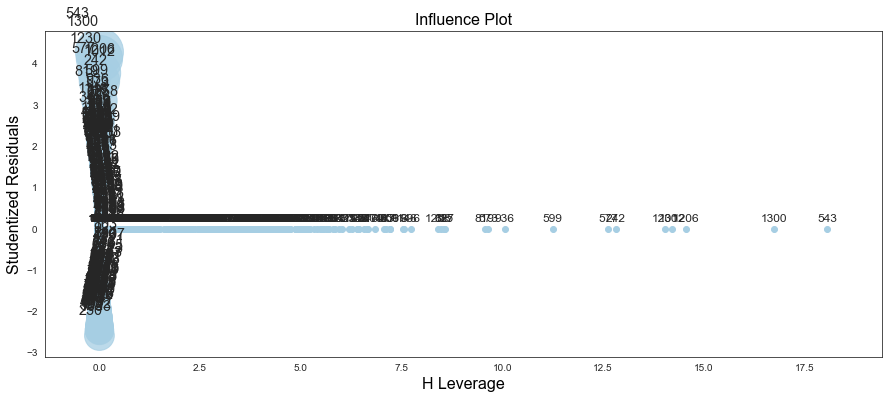

In [79]:
# Run the OLS model for smoker_yes only
results_smoker = sm.ols(formula='charges ~ smoker_yes', data=Insurance_df).fit()

# Plot the residual leverage plots
fig, ax = plt.subplots(figsize=(15,6))
fig = plot_leverage_resid2(results_smoker, ax=ax)
fig = influence_plot(results_smoker, ax=ax)

As this variable (smoker_yes) is a binary categorical variable, the residual plots are difficult to decipher. We should also run the OLS model and compare the influence plots for the next most impacting variable (age)

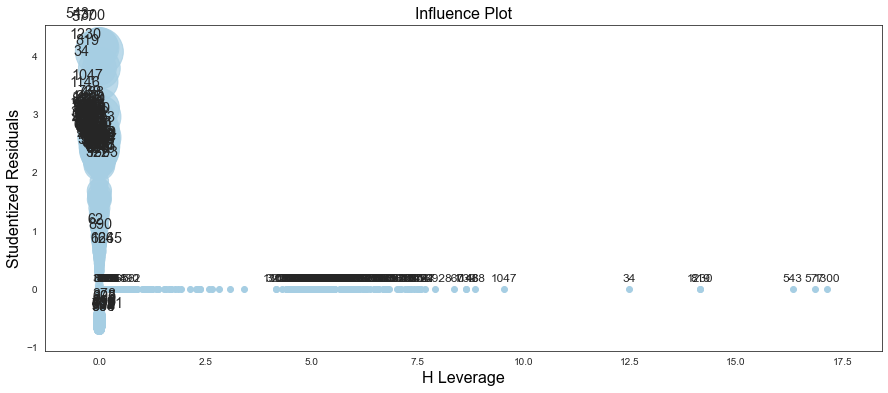

In [80]:
# Run the OLS model for age only
results_age = sm.ols(formula='charges ~ age', data=Insurance_df).fit()

# Plot the residual leverage plots
fig, ax = plt.subplots(figsize=(15,6))
fig = plot_leverage_resid2(results_age, ax=ax)
fig = influence_plot(results_age, ax=ax)

Based on the above influence plots, you can see that some points could be considered as outliers (34, 543, 577, 819, 1230 & 1300). We will try the OLS regression modelling again to see if there is any impact on the results.

In [81]:
# Remove the outliers from the dataset (creating new dataframe)
Insurance_df_no_outlier = Insurance_df.drop([34, 543, 577, 819, 1230, 1300])

In [82]:
fwd_sel_regression(Insurance_df_no_outlier, dep_variable, all_ind_variables, [])


R-Squared values for the independent variables
╒═══════════════════════════╤═════════════╕
│ Independent Variable(s)   │   R-Squared │
╞═══════════════════════════╪═════════════╡
│ age                       │       0.094 │
├───────────────────────────┼─────────────┤
│ bmi                       │       0.035 │
├───────────────────────────┼─────────────┤
│ children                  │       0.006 │
├───────────────────────────┼─────────────┤
│ smoker_yes                │       0.618 │
├───────────────────────────┼─────────────┤
│ sex_male                  │       0.004 │
├───────────────────────────┼─────────────┤
│ region_northwest          │       0.002 │
├───────────────────────────┼─────────────┤
│ region_southeast          │       0.005 │
├───────────────────────────┼─────────────┤
│ region_southwest          │       0.002 │
╘═══════════════════════════╧═════════════╛


In [83]:
fwd_sel_regression(Insurance_df_no_outlier, dep_variable, all_ind_variables, ['smoker_yes'])


R-Squared values for the independent variables
╒═══════════════════════════════╤═════════════╕
│ Independent Variable(s)       │   R-Squared │
╞═══════════════════════════════╪═════════════╡
│ smoker_yes + age              │       0.725 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + bmi              │       0.655 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + children         │       0.622 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + sex_male         │       0.618 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + region_northwest │       0.618 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + region_southeast │       0.618 │
├───────────────────────────────┼─────────────┤
│ smoker_yes + region_southwest │       0.618 │
╘═══════════════════════════════╧═════════════╛


In [84]:
fwd_sel_regression(Insurance_df_no_outlier, dep_variable, all_ind_variables, ['smoker_yes', 'age'])


R-Squared values for the independent variables
╒═════════════════════════════════════╤═════════════╕
│ Independent Variable(s)             │   R-Squared │
╞═════════════════════════════════════╪═════════════╡
│ smoker_yes + age + bmi              │       0.75  │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + children         │       0.728 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + sex_male         │       0.725 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + region_northwest │       0.725 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + region_southeast │       0.726 │
├─────────────────────────────────────┼─────────────┤
│ smoker_yes + age + region_southwest │       0.725 │
╘═════════════════════════════════════╧═════════════╛


In [85]:
fwd_sel_regression(Insurance_df_no_outlier, dep_variable, all_ind_variables, ['smoker_yes', 'age', 'bmi'])


R-Squared values for the independent variables
╒═══════════════════════════════════════════╤═════════════╕
│ Independent Variable(s)                   │   R-Squared │
╞═══════════════════════════════════════════╪═════════════╡
│ smoker_yes + age + bmi + children         │       0.752 │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + sex_male         │       0.75  │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + region_northwest │       0.75  │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + region_southeast │       0.75  │
├───────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + region_southwest │       0.75  │
╘═══════════════════════════════════════════╧═════════════╛


In [86]:
fwd_sel_regression(Insurance_df_no_outlier, dep_variable, all_ind_variables, ['smoker_yes', 'age', 'bmi', 'children'])


R-Squared values for the independent variables
╒══════════════════════════════════════════════════════╤═════════════╕
│ Independent Variable(s)                              │   R-Squared │
╞══════════════════════════════════════════════════════╪═════════════╡
│ smoker_yes + age + bmi + children + sex_male         │       0.752 │
├──────────────────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + children + region_northwest │       0.753 │
├──────────────────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + children + region_southeast │       0.753 │
├──────────────────────────────────────────────────────┼─────────────┤
│ smoker_yes + age + bmi + children + region_southwest │       0.753 │
╘══════════════════════════════════════════════════════╧═════════════╛


The results show a minor overall increase to the final R-Squared value (from 0.750 to 0.752) with the removal of the 6 outliers, as outlined below.

FINAL MODEL

In [87]:
# Get the results summary from the final model
results_no_outlier = sm.ols(formula='charges ~ smoker_yes + age + bmi + children', data=Insurance_df_no_outlier).fit()
results_no_outlier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1008.
Date:                Mon, 12 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:33:26   Log-Likelihood:                -13442.
No. Observations:                1332   AIC:                         2.689e+04
Df Residuals:                    1327   BIC:                         2.692e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.156e+04    911.683    -12.677      0.000   -1.33e+04   -9768.815
smoker_yes[T.1]  2.327e+04    400.148     58.153      0.000    2.25e+04    2.41e+04
age               257.4016     11.487     22.408      0.000     234.867     279.936
bmi               303.6875     26.513     11.454      0.000     251.676     355.699
children          500.0492    133.151      3.755      0.000     238.839     761.259
==============================================================================
Omnibus:                      263.912   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              534.941
Skew:                           1.146   Prob(JB):                    6.90e-117
Kurtosis:                       5.094   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Comparison model with lower R-Squared

In [88]:
results = sm.ols(formula='charges ~ smoker_yes + age + bmi + children', data=Insurance_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     998.1
Date:                Mon, 12 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:33:26   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -1.21e+04    941.984    -12.848      0.000    -1.4e+04   -1.03e+04
smoker_yes[T.1]  2.381e+04    411.220     57.904      0.000     2.3e+04    2.46e+04
age               257.8495     11.896     21.675      0.000     234.512     281.187
bmi               321.8514     27.378     11.756      0.000     268.143     375.559
children          473.5023    137.792      3.436      0.001     203.190     743.814
==============================================================================
Omnibus:                      301.480   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              722.157
Skew:                           1.215   Prob(JB):                    1.53e-157
Kurtosis:                       5.654   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""